<a href="https://colab.research.google.com/github/mjg-phys/cdm-computing-subgroup/blob/main/DMRelicDensityTutorial/DM_freezeout_intro_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Intro to Google Colab**

- Can run in the cloud or locally - if you already have python and jupyter installed, then just launch a notebook: 'jupyter notebook' and copy the URL

- Built-in access to documentation

- Basic stack inspector

- Colab AI tool (Note: AI tools for programming are a fast moving field, they are typically based on large langauge models (very fancy autocomplete). They vary in their usefulness, but are definitely something to keep your eye on.)

# **Dark matter freeze out and relic density**

- This notebook computes the relic density of dark matter after freezeout by numerically solving the Boltzmann equation

- The purpose of the notebook is to teach/refresh some basic python skills and demonstrate how to layout a notebook

- All units are in powers of GeV unless noted explicitly

## Import requried packages

In [1]:
import numpy as np

from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.special import kv
from scipy.optimize import root

import matplotlib as mpl
import matplotlib.pyplot as plt

from google.colab import files

##Define constants

In [2]:
#Units given in GeV with hbar = c = 1
Centimeter = 5.06773e13 #1/GeV
Meter = 100 * Centimeter
Kilometer = 1e5 * Centimeter
Parsec = 3.086e18 * Centimeter

Second = 1.51927e24 #1/GeV
Year = 365.25 * 24 * 3600 * Second

Kelvin = 8.61733e-14 #GeV

Kilogram = 5.6101e26 #GeV

#Physical constants
Gnewton = 6.67e-11 * Meter**3 / Kilogram / Second**2  #Gravitational constant
M_pl = 1.22e19                                        #Plank mass in GeV
geff = 100.      #approx number of degrees of freedom in Standard Model

# Approximate calculation



In this section we will perform an approximate calculation as an example (below, as an exercise you will make several improvements). Here the standard model degrees of freedom are taken to be constant ($g^*=100$) and so this is most appropriate for heavy DM that freeze out at temperatures above $\sim 100$ GeV

The Boltzmann equation which defines how the dark matter number density, $n$, evolves with time, $t$, is:

$\frac{dn}{dt} = -3H(t) n - \langle \sigma v \rangle (n^2 - n_{eq}^2)$

where, $H$ is the Hubble constant (expanding Universe dilutes density) and $\langle \sigma v \rangle$ is the thermally averaged cross section (times velocity) of the dark matter annihilating to standard model particles.

To solve this we need to know the Hubble constant, which we get from solving the Friedman equations. At early times the Universe is radiation dominated, giving:

$H^2 = \left(\frac{\dot{a}}{a}\right) = \frac{8\pi^3}{90 m_{pl}^2}g_{eff}(T) T^4$

Where $m_{pl}$ is the Planck mass, $g_{eff}$ are the degrees of freedom of the Standard Model plasma and $T$ is the temperature (taken to be photon temperature).

To relate $H$ to time, we use the fact that (again during radiation domination):

$a(t) = a_0 t^{1/2}$

Implying:

$H = 1/(2t)$

And the equilibrium number density at temperature, T, of a particle with mass, m, and total degrees of freedom, g, is:

$n_{eq}(T) = \frac{g m_\chi^2}{2 \pi^2} T K_2(m_\chi/T)$

where $K_2$ is a modified Bessel function of the second kind.



##Functions definitions

In [3]:
#This function takes a time (in 1/GeV), and returns the hubble parameter (in GeV)
# of the universe at that time
def HubbleAtTime(time):
    return 1/(2 * time)

#Takes Temp (in GeV), and returns the hubble parameter (in GeV)
# of the universe when it was that temperature
def HubbleAtTemp(Temp):
    return np.sqrt(8 * np.pi**3 * geff / 90 ) * Temp**2 / M_pl

#This function takes a temperature, Temp (in GeV), and returns the time (in 1/GeV)
# the universe was at that temperature
def timeAtTemp(Temp):
    H = HubbleAtTemp(Temp)
    return 1/2./H

#This function takes a time (in 1/GeV), and returns the temperature (in GeV) the
# universe was at that time
def TempAtTime(time):
    H = HubbleAtTime(time)
    return np.sqrt( H / np.sqrt(8 * np.pi**3 * geff / (90 * M_pl**2 )  ) ) #units of GeV

In [4]:
#Returns the equilibrium number density (in GeV^3) at time t, for a particle with
# mass = mDM and gDM degrees of freedom
def n_eq( time, mDM, gDM):
    Temp = TempAtTime(time)
    return gDM * mDM**2 * Temp * kv(2, mDM/Temp) / (2 * np.pi**2)

#This is the right-hand-side of the Boltzmann eqn. i.e. it returns dn/dt (GeV^4)
# at a given time, t, number density, n, for DM mass mDM, annihilation
# cross section, sigmav, and number of degrees of freedom, gDM
def BoltzmannEqnRHS( t, n, mDM, sigmav, gDM):
    return -3*HubbleAtTime(t)*n - sigmav*(n**2 - n_eq(t,mDM,gDM)**2)


#Solve the Boltzmann equation for a given dark matter mass, mDM, annihilation
# cross section, sigmav, number of degrees of freedom, gDM
# numPoints controls the number of log-spaced function evaluations returned
# between the time when temperature is .01*mDM and 1e4*mDM
# a list of two arrays is returned: (t_values, n_values)
def solve_BoltzEqn( mDM, sigmav, gDM, numPoints):

    #This makes sure we start in equilibrium and end after freezeout
    t_start = timeAtTemp(mDM) * 1e-2
    t_end   = timeAtTemp(mDM) * 1e4
    t_array = np.logspace(np.log10(t_start*1.001),np.log10(t_end*0.999),numPoints)

    #calculate initial equilibrium density
    nInitial = n_eq(t_array[0],mDM,gDM)

    #solve the ODE using SciPy., with sub-percent precision
    sol = solve_ivp(BoltzmannEqnRHS, [t_start,t_end], [nInitial], method='Radau',\
                    args=(mDM,sigmav,gDM), t_eval=t_array, rtol=1e-3, atol=1e-13)

    #Check if there were any problems with the integration
    if sol.status == 0:
        return (sol.t,sol.y[0])
    else:
        print("Integration failed")
        return -1

## Example freezeout calculation

Here we solve the Boltzmann equation for a dark matter particle with $m_\chi$ = 100 GeV and $\langle\sigma v \rangle = 3\times10^{-26}$ cm$^{3}$s$^{-1}$

In [5]:
nVsTime_mDM100 = solve_BoltzEqn( 100, 3e-26 * Centimeter**3/Second, 2, 100)

Now we will create a figure of dark matter density vs. time using the above solution:

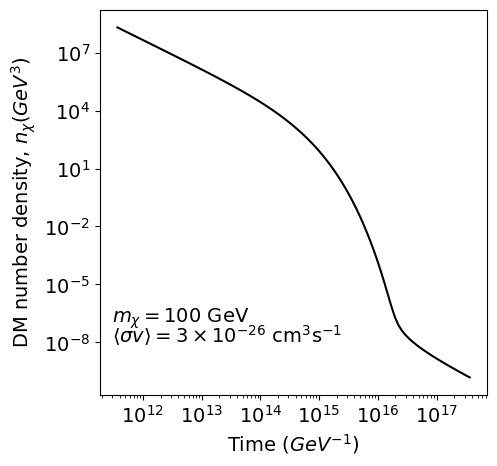

In [7]:
#Plot the solution
fig1 = plt.figure( figsize = (5,5))
plt.plot( nVsTime_mDM100[0], nVsTime_mDM100[1], 'k-')

#Setup axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Time $(GeV^{-1})$",fontsize=14)
plt.ylabel(r"DM number density, $n_\chi (GeV^{3})$",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#Add text for WIMP properties
plt.text(3e11,1e-7,r"$m_\chi = 100$ GeV",fontsize=14)
plt.text(3e11,1e-8,r"$\langle\sigma v \rangle = 3\times10^{-26}$ cm$^{3}$s$^{-1}$",fontsize=14)

plt.show()

**Warm up exercise**

Replot the above figure with the following changes:

- divide the number density by temperature$^3$ (this will factor out the expansion of the Universe)
- put time in units of seconds
- add a curve for the equilibrium number density (use `n_eq(t,m,g)`)

What do you see? what does this say about dark matter/standard model interactions?

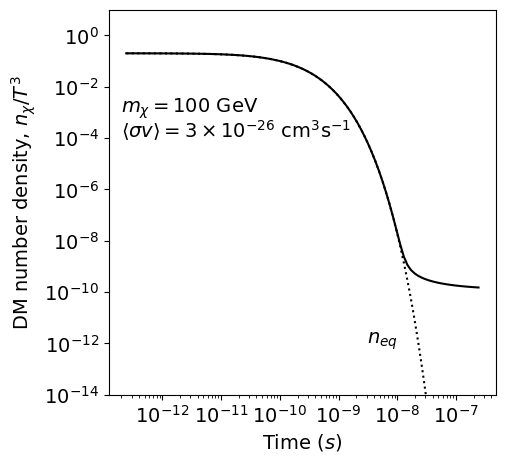

In [ ]:
#ANSWER

#Compute n_eq values at the same set of time values
n_eq_vals = list(n_eq( t, 100, 2) for t in nVsTime_mDM100[0])

#Plot curves
fig1 = plt.figure(figsize=(5,5))
plt.plot(nVsTime_mDM100[0]/Second,nVsTime_mDM100[1]/TempAtTime(nVsTime_mDM100[0])**3,'k-',\
         nVsTime_mDM100[0]/Second, n_eq_vals/TempAtTime(nVsTime_mDM100[0])**3, 'k:')

#Setup axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Time $(s)$",fontsize=14)
plt.ylabel(r"DM number density, $n_\chi/T^3$",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(1e-14,1e1)

#Add text for WIMP properties
plt.text(2e-13,1e-3,r"$m_\chi = 100$ GeV",fontsize=14)
plt.text(2e-13,1e-4,r"$\langle\sigma v \rangle = 3\times10^{-26}$ cm$^{3}$s$^{-1}$",fontsize=14)
plt.text(3e-9,1e-12,r"$n_{eq}$",fontsize=14)

plt.show()

In [ ]:
#ANSWER


# Better calculation

Here we will re-cast the problem to make it more accurate and easier to solve.

First, we divide the number density by the entropy density, $s$, which is conserved in a co-moving volume, giving a dimensionless quantity called the *yield*:

$Y = n/s$

Where the entropy density at temperature, $T$ is:

$s = \frac{2\pi^2}{45} h_{eff}(T) T^3 $

Where $h_{eff}$ are the number of entropic degrees of freedom. We can then evolve with temperature of the universe. For convenience, rather than evolving in temperature, we use the dimensionless parameter, $x$:

$x = m_\chi/T$

The Boltzmann equation you arrive at is then (for details see e.g. [this chapter](https://arxiv.org/abs/1009.3690) from *Particle Dark Matter*):

$\frac{dY}{dx} = - \sqrt{\frac{\pi\, m_{\rm{pl}}^2}{45}} \frac{g_*^{1/2}(T) \,m_\chi}{x^2} \langle\sigma v \rangle(Y^2-Y_{\rm{eq}}^2)$

The function $g_*^{1/2}(T)$ is a function of $g_{eff}$ and $h_{eff}$ (see above reference for details). In this exercise we will interpolate some 'data' of $g_*^{1/2}(T)$, provided below.

**Exercise 1**

Your task is to reproduce the figure below.

To do so you will need to:

- Create a function which interpolate the below data for $g_*^{1/2}(T)$ and $h_{\rm{eff}}$ (use the `interp1d` function)

- Write a new function for solving the Boltzmann eqn in terms of $dY/dx$ (the same numerical method will work)

- Plot $Y_{eq}$

- Modify the plot to include the extra curve with different formatting (check the documentation, or ask Colab AI)

In [ ]:
#Create the interpolating functions from this data:

gs_half_T_vals=(0.00002, 0.00004, 0.00007, 0.00008, 0.0001, 0.00013, 0.00018, \
0.00033, 0.00069, 0.00453, 0.01113, 0.02116, 0.03112, 0.05917, \
0.09081, 0.12257, 0.14548, 0.16543, 0.22327, 0.40673, 0.65156, \
1.23886, 2.35555, 4.87946, 9.27773, 20.0598, 29.4963, 43.372, \
69.4801, 170.828, 798.593, 10000.)

gs_half_vals=(2.12996, 2.12996, 2.25993, 2.51986, 2.77978, 3.08303, 3.213, 3.25632, \
3.29964, 3.29964, 3.29964, 3.64621, 3.81949, 4.12274, 4.38267, \
5.20578, 6.41877, 7.5018, 7.84838, 8.15162, 8.41155, 8.88809, \
9.14801, 9.14801, 9.23466, 9.45126, 9.71119, 9.9278, 10.1444, \
10.2744, 10.2744, 10.2744)

h_eff_T_vals=(0.00002, 0.00007, 0.00012, 0.00022, 0.00041, 0.00089, 0.00297, \
0.01226, 0.02335, 0.03437, 0.05753, 0.08839, 0.13008, 0.14797, \
0.1834, 0.21777, 0.29412, 0.43288, 0.66503, 0.97876, 1.56965, \
2.21304, 4.21414, 8.0247, 15.2809, 19.7714, 33.0989, 48.7131, \
68.6799, 96.8309, 162.103, 336.362, 697.948, 2131.43, 9177.07)

h_eff_vals=(3.91304, 3.58696, 5.54348, 7.82609, 9.45652, 10.7609, 11.087, \
10.7609, 11.7391, 13.0435, 15., 16.6304, 20.2174, 27.3913, 39.1304, \
46.9565, 56.087, 61.6304, 66.8478, 72.0652, 75.3261, 78.913, 81.5217, \
83.1522, 83.8043, 86.413, 89.6739, 94.8913, 97.5, 100.761, 102.391, \
103.696, 104.348, 104.348, 104.348)

#These functions interpolate the above data, they will take Temp (GeV) as input
# and return the degrees of freedom at that temperature
gs_half = interp1d( gs_half_T_vals, gs_half_vals, fill_value=( gs_half_vals[0], gs_half_vals[-1]), bounds_error=False)
h_eff   = interp1d( h_eff_T_vals, h_eff_vals, fill_value=( h_eff_vals[0], h_eff_vals[-1]), bounds_error=False)


In [ ]:
#Function for computing the equilibrium yield of a DM particle with mass mDM (GeV) and
# gDM degrees of freedom, at (scaled) temperature x = m/T
def Y_eq( x, mDM, gDM):
    return 45 * x**2 * gDM * kv(2, x) / ( 4 * np.pi**4 * h_eff( mDM / x ))

#This function returns dY/dx (the right hand side of boltzmann eqn) for a
# given (scaled) temperature x = mDM/T, yield Y, DM mass mDM (GeV), degrees of freedom gDM,
# and annihilation cross section sigmav (1/GeV^2)
def Y_BoltzmannEqnRHS( x, Y, mDM, sigmav, gDM):
    return -np.sqrt( np.pi * M_pl**2 / 45 ) * gs_half( mDM / x ) * mDM / x**2 * sigmav * (Y**2 - Y_eq(x,mDM,gDM)**2)


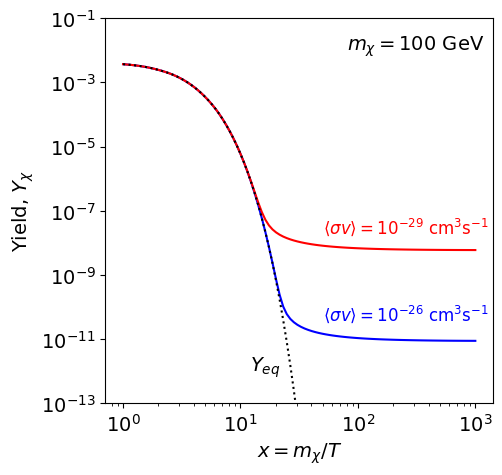

In [ ]:
fig1 = plt.figure(figsize=(5,5))
plt.plot(YvsX_mDM100_svWeak[0], YvsX_mDM100_svWeak[1], 'b-',\
         YvsX_mDM100_svWeaker[0], YvsX_mDM100_svWeaker[1], 'r-',\
         YvsX_mDM100_svWeak[0], Y_eqVals, 'k:')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$x = m_\chi / T$",fontsize=14)
plt.ylabel(r"Yield, $Y_\chi$",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(1e-13,1e-1)

#Add text for WIMP properties
plt.text(80,1e-2,r"$m_\chi = 100$ GeV",fontsize=14)
plt.text(50,4e-11,r"$\langle\sigma v \rangle = 10^{-26}$ cm$^{3}$s$^{-1}$",fontsize=12,color='blue')
plt.text(50,2e-8,r"$\langle\sigma v \rangle = 10^{-29}$ cm$^{3}$s$^{-1}$",fontsize=12,color='red')
plt.text(12,1e-12,r"$Y_{eq}$",fontsize=14)

plt.savefig("fig_dm_freezeout.pdf")

plt.show()

Things you can explore:
- Different WIMP cross sections or masses
- Verify your result against one from the literature (e.g. Fig.1 of [arXiv:1204.3622](https://arxiv.org/abs/1204.3622))
- Accuracy vs. speed (play around with options `rtol` and `atol`)


 **Download figure**

This is slightly more complicated in colab, we need an extra step to get the file, either use the function: `from google.colab import files`, or the sidebar to download the figure to our computer:



In [ ]:
files.download("fig_dm_freezeout.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Relic density

So we've calculated the freezeout process, now let's calculate the relic density of DM that corresponds to. This is normally expressed as a fraction of the critical density:

$\Omega_\chi = \frac{\rho_\chi}{\rho_{\rm{critical}}} $

Where:

$\rho_\chi = m_\chi n_\chi(t_0) =  m_\chi s_0 Y_{\chi,0}$

$\rho_{\rm{critical}} = \frac{3 H_0^2}{8\pi G}$

Within the standard cosmological model ($\Lambda\rm{CDM}$), fits to the density fluctuations of the CMB indicate $\Omega_\chi \sim 0.26$

Given the (ongoing) uncertainty in the Hubble constant, it is common to see the density expressed with it factored out:

$\Omega_\chi h^2 = 0.120\pm0.001$ (from [Planck](https://arxiv.org/abs/1807.06209))

Where $h = \frac{H_0}{100\rm{km/s/Mpc}}$


**Exercise 2**

Using the above equations (and our previously defined functions) create a function which takes as input WIMP mass, $m_\chi$, annihilation cross section, $\langle\sigma v \rangle$, and WIMP degrees of freedom, $g_\chi$, and computes the expected relic density ($\Omega_\chi h^2$).

(Hint: to calculate $s_0$ use the equation given above and the present CMB photon temp)

In [ ]:
#ANSWER


#Stretch goals:


**Exercise 3**

Make a plot of the annihilation cross section which reproduces the correct relic density as a function of WIMP mass

In [ ]:
#ANSWER


**Exercise 4**

Modify the code to do freeze in of DM

Hint: the main difference is the initial conditions for freeze in

In [ ]:
#ANSWER

# Acknowledgements

This notebook is partly based of code by Ben Safdi, and Josh Wood and Innes Bigaran.
